In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Import the selected features dataset (Natural Gas demand and Weather factors)

This dataset is the historical daily natural gas demand in energy unit (TJ/d) andselected  weatherfactors  data in Saskatchewan from November 1, 2013 to October 31, 2023 The selected weather features are Lowest Relative Humidity, Heating Degree Days, Lowest Temperature, Average Temperature, and Highest Temperature. These were based on the  



In [2]:
# Import the merged dataset (Natural Gas demand and Weather factors)
selected_features_df = pd.read_csv('../data/selected_features.csv')
selected_features_df.head()

,DATE,NG_DEMAND,LOWEST_REL_HUMIDITY,HEATING_DEGREE_DAYS,LOWEST_TEMPERATURE,AVG_TEMPERATURE,HIGHEST_TEMPERATURE
0,2013-11-01,617,44.400000,14.833333,-2.933333,3.166667,9.206667
1,2013-11-02,630,34.133333,16.293333,-5.866667,1.706667,9.266667
2,2013-11-03,688,60.133333,16.726667,-2.166667,1.273333,4.706667
3,2013-11-04,815,66.466667,23.540000,-9.106667,-5.540000,-1.906667
4,2013-11-05,789,53.000000,27.820000,-14.966667,-9.820000,-4.633333


In [3]:
# Prepare this dataset for cross-validation prophet modelling 
selected_features_df_mod = selected_features_df.copy()
selected_features_df_mod.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'}, inplace=True)

In [4]:
# Split the data into training set from 2013-11-01 to 2021-10-31, and using 2021-11-01 to 2023-10-31 as test/validation set
train_df = selected_features_df[selected_features_df['DATE'] < '2021-12-01']
validation_df = selected_features_df[selected_features_df['DATE'] >= '2021-12-01']

# Print the shape of the train-test split
print(train_df.shape)
print(validation_df.shape)

(2952, 7)
(700, 7)


## Step 3: Model Development
In this step, the model development includ all the improved models used in the "model_building.ipynb" notebookaare repeated in this notebook ford the model performanc on selected featurese.

### Prophet Modelth Prophet

18:48:49 - cmdstanpy - INFO - Chain [1] start processing
18:48:53 - cmdstanpy - INFO - Chain [1] done processing


Best Parameters: {'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'yearly_seasonality': True}


  0%|          | 0/4 [00:00<?, ?it/s]

18:48:53 - cmdstanpy - INFO - Chain [1] start processing
18:48:55 - cmdstanpy - INFO - Chain [1] done processing
18:48:55 - cmdstanpy - INFO - Chain [1] start processing
18:48:57 - cmdstanpy - INFO - Chain [1] done processing
18:48:58 - cmdstanpy - INFO - Chain [1] start processing
18:48:59 - cmdstanpy - INFO - Chain [1] done processing
18:49:01 - cmdstanpy - INFO - Chain [1] start processing
18:49:03 - cmdstanpy - INFO - Chain [1] done processing


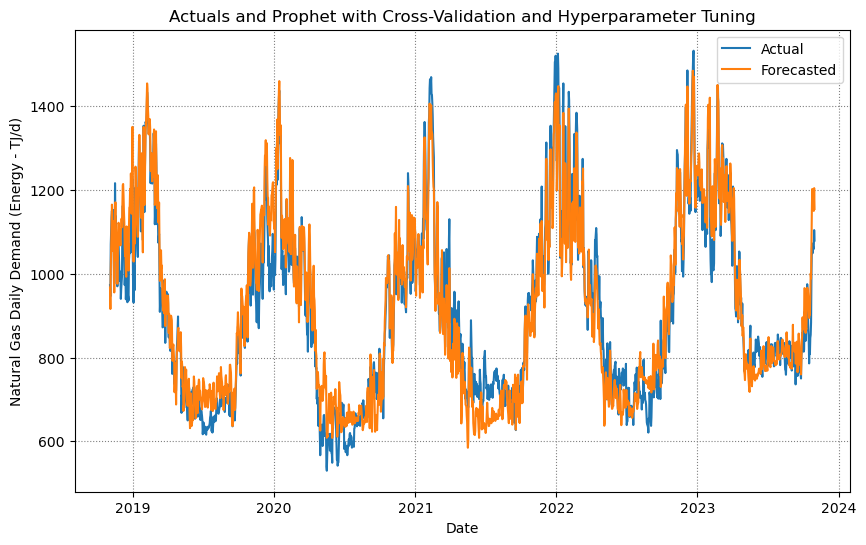

Mean Absolute Error: 46.22
Mean Squared Error: 3344.38
Root Mean Squared Error: 57.83
R-squared: 0.93
Mean Absolute Percentage Error: 5.40%
Median Absolute Percentage Error: 4.33%


In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet
from sklearn.base import BaseEstimator, RegressorMixin
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import numpy as np

class ProphetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, yearly_seasonality=True, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0):
        self.yearly_seasonality = yearly_seasonality
        self.seasonality_mode = seasonality_mode
        self.seasonality_prior_scale = seasonality_prior_scale
        self.holidays_prior_scale = holidays_prior_scale
        self.model = None

    def fit(self, X, y=None):
        # Initialize the Prophet model with the given hyperparameters
        self.model = Prophet(yearly_seasonality=self.yearly_seasonality, seasonality_mode=self.seasonality_mode, 
                             seasonality_prior_scale=self.seasonality_prior_scale, holidays_prior_scale=self.holidays_prior_scale)
        
        # Add additional regressors
        for regressor in ['LOWEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE']:
            self.model.add_regressor(regressor)

        # Fit the model to the data
        self.model.fit(X)

        return self

    def predict(self, X):
        # Use the fitted model to make predictions
        return self.model.predict(X)

# Define parameter grid for hyperparameter tuning
param_grid = {'yearly_seasonality': [True, False], 
              'seasonality_mode': ['additive', 'multiplicative'], 
              'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0], 
              'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]}

# Instantiate the model
model = ProphetWrapper()

# Perform grid search to find the best model
grid_search = GridSearchCV(model, param_grid, cv=4, n_jobs=-1)  # Adjust cv and n_jobs as needed
grid_search.fit(selected_features_df_mod)

# Print best parameters
print(f'Best Parameters: {grid_search.best_params_}')

# Perform cross-validation with the best model
df_cv_mp = cross_validation(grid_search.best_estimator_.model, initial='1825 days', period='456 days', horizon='456 days')

# Calculate performance metrics
df_metrics_mp = performance_metrics(df_cv_mp)

# Plotting actuals and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_cv_mp['ds'], df_cv_mp['y'], label='Actual')
plt.plot(df_cv_mp['ds'], df_cv_mp['yhat'], label='Forecasted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Natural Gas Daily Demand (Energy - TJ/d)')
# Add a grid to the figure for better visualization of data
plt.grid(linestyle=":", color='grey')
plt.title('Actuals and Prophet with Cross-Validation and Hyperparameter Tuning')
plt.show()

# Calculate MAE, MSE, RMSE, and R-squared
mae_mp = mean_absolute_error(df_cv_mp['y'], df_cv_mp['yhat'])
mse_mp = mean_squared_error(df_cv_mp['y'], df_cv_mp['yhat'])
rmse_mp = np.sqrt(mse_mp)
r2_mp = r2_score(df_cv_mp['y'], df_cv_mp['yhat'])
mape_mp = np.mean(np.abs((df_cv_mp['y'] - df_cv_mp['yhat']) / df_cv_mp['y'])) * 100
mdape_mp = np.median(np.abs((df_cv_mp['y'] - df_cv_mp['yhat']) / df_cv_mp['y'])) * 100

print(f'Mean Absolute Error: {mae_mp:.2f}')
print(f'Mean Squared Error: {mse_mp:.2f}')
print(f'Root Mean Squared Error: {rmse_mp:.2f}')
print(f'R-squared: {r2_mp:.2f}')
print(f'Mean Absolute Percentage Error: {mape_mp:.2f}%')
print(f'Median Absolute Percentage Error: {mdape_mp:.2f}%')

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=1.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=1.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 5
[LightGBM] [Info] Start training from score 730.991233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters found by grid sear

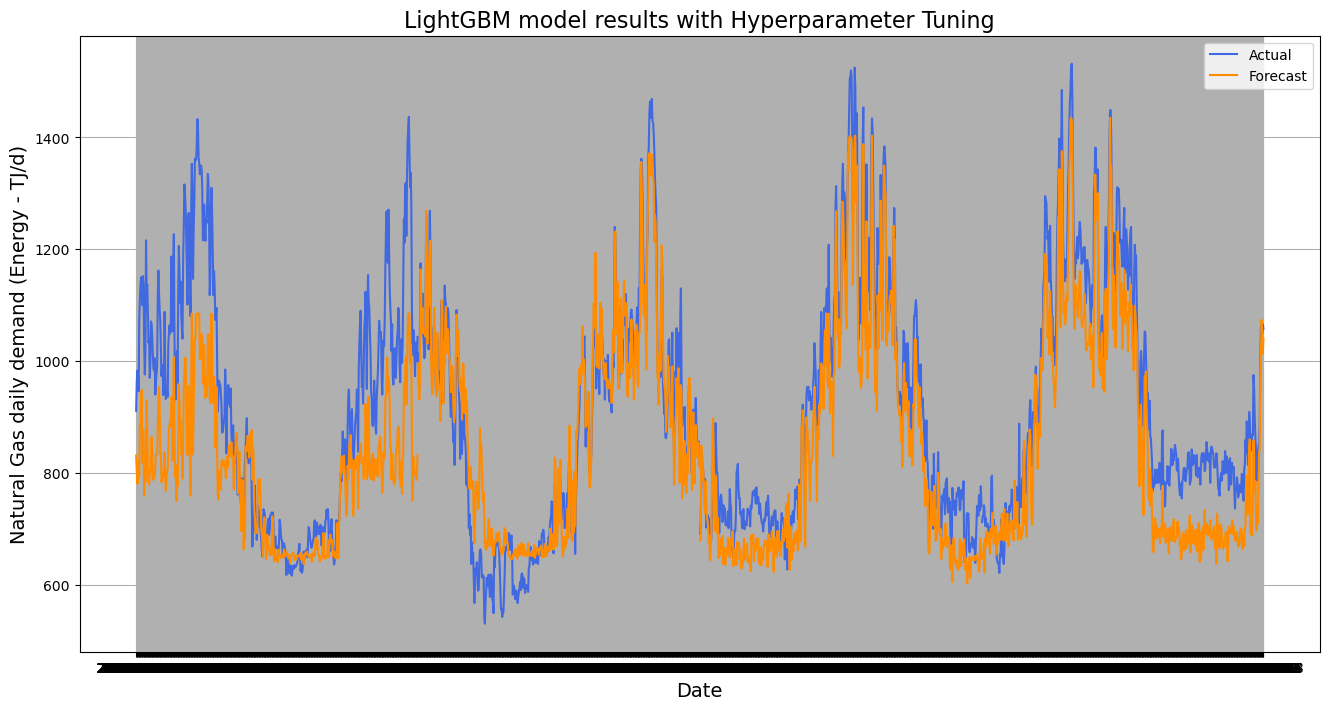

Average Mean Squared Error: 12302.980
Average Root Mean Squared Error: 102.885
Average Mean Absolute Percentage Error: 9.039
Average Mean Absolute Error: 84.598
Average Median Absolute Percentage Error: 8.817
Average R-squared: 0.729


In [10]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

# Assuming df is your DataFrame and 'NG_DEMAND' is the column with values to predict
X = selected_features_df[['DATE', 'LOWEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',  
        'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE']]
y = selected_features_df['NG_DEMAND']

# Define the model parameters
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'force_col_wise': True,  # Add the force_col_wise parameter
    'min_child_samples': 20,  # Adjust this value
    'min_data_in_leaf': 20,    # Adjust this value
    'min_split_gain': 0.01,  # Adjust this value
}

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [31, 50, 100, 200],
    'reg_alpha': [0.1, 0.5, 1.0],
    'lambda_l1': [0, 0.1, 0.5, 1],
    'lambda_l2': [0, 0.1, 0.5, 1],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [20, 40, 60, 80, 100],
}

# Initialize the total performance metrics
total_mse, total_rmse, total_mape, total_mae, total_mdape, total_r2 = 0, 0, 0, 0, 0, 0

# Function to train and evaluate a model for a given split
def train_evaluate_model(X_train, X_test, y_train, y_test):
    # Create a LightGBM dataset for training
    train_data = lgb.Dataset(X_train, label=y_train)

    # Perform grid search
    gbm = lgb.LGBMRegressor(**lgb_params)
    randomsearch = RandomizedSearchCV(estimator=gbm, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=4, verbose=1, n_jobs=-1)
    randomsearch.fit(X_train.drop(columns=['DATE']), y_train)
    
    print("Best parameters found by grid search are:", randomsearch.best_params_)
    
    # Use the best estimator directly
    gbm_best = randomsearch.best_estimator_
    
    # Train the model with the best parameters
    gbm_best.fit(X_train.drop(columns=['DATE']), y_train)
    
    # Predict on the test set
    y_pred = gbm_best.predict(X_test.drop(columns=['DATE']))

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mae = mean_absolute_error(y_test, y_pred)
    mdape = np.median(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    return mse, rmse, mape, mae, mdape, r2, y_pred

# Calculate the number of folds
n_splits = (len(X) - train_size) // test_size

plt.figure(figsize=(16, 8))

# Loop over the splits
for i in range(n_splits):
    train_start = i * test_size
    train_end = train_start + train_size
    test_end = train_end + test_size

    # Train and evaluate the model for the current split
    result = train_evaluate_model(
        X.iloc[train_start:train_end], X.iloc[train_end:test_end],
        y.iloc[train_start:train_end], y.iloc[train_end:test_end]
    )

    # Accumulate the performance metrics
    total_mse += result[0]
    total_rmse += result[1]
    total_mape += result[2]
    total_mae += result[3]
    total_mdape += result[4]
    total_r2 += result[5]

    # Plot the forecast and actuals for each split
    plt.plot(X.iloc[train_end:test_end]['DATE'], y.iloc[train_end:test_end],  color='royalblue', label='Actual')
    plt.plot(X.iloc[train_end:test_end]['DATE'], result[6], color='darkorange', label='Forecast')

# Calculate the average folds performance metrics
mse_lgbm2 = total_mse / n_splits
rmse_lgbm2 = total_rmse / n_splits
mape_lgbm2 = total_mape / n_splits
mae_lgbm2 = total_mae / n_splits
mdape_lgbm2 = total_mdape / n_splits
r2_lgbm2 = total_r2 / n_splits

# Plot the forecast and actuals with the DATE column
plt.title('LightGBM model results with Hyperparameter Tuning', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Natural Gas daily demand (Energy - TJ/d)', fontsize=14)

# Only add the legend once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid()
plt.show()

# Print the results
print(f'Average Mean Squared Error: {mse_lgbm2:.3f}')
print(f'Average Root Mean Squared Error: {rmse_lgbm2:.3f}')
print(f'Average Mean Absolute Percentage Error: {mape_lgbm2:.3f}')
print(f'Average Mean Absolute Error: {mae_lgbm2:.3f}')
print(f'Average Median Absolute Percentage Error: {mdape_lgbm2:.3f}')
print(f'Average R-squared: {r2_lgbm2:.3f}')


In [11]:
import pandas as pd
from prophet import Prophet

temp_df = selected_features_df.copy()

def prophet_features(df, horizon=24*7):
    temp_df = df[['DATE', 'NG_DEMAND']].rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'})
    
    # Using the data from the previous week as an example for validation
    train, test = temp_df.iloc[:-horizon, :],  temp_df.iloc[-horizon:, :]

    # Define the Prophet model
    m = Prophet(
        growth='linear',
        seasonality_mode='additive',
        interval_width=0.95,
        yearly_seasonality=True,

    )
    
    # Train the Prophet model
    m.fit(train)

    # Extract features from the data, using Prophet to predict the training set
    predictions_train = m.predict(train.drop('y', axis=1))
    
    # Use Prophet to extract features from the data to predict the test set
    predictions_test = m.predict(test.drop('y', axis=1))
    
    # Combine predictions from the training and test sets
    predictions = pd.concat([predictions_train, predictions_test], axis=0)

    return predictions[['ds', 'trend', 'yhat_lower', 'yhat_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'yhat']]

features = prophet_features(temp_df)

02:10:40 - cmdstanpy - INFO - Chain [1] start processing
02:10:42 - cmdstanpy - INFO - Chain [1] done processing


02:11:27 - cmdstanpy - INFO - Chain [1] start processing
02:11:28 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4387
[LightGBM] [Info] Number of data points in the train set: 1823, number of used features: 18
[LightGBM] [Info] Start training from score 731.418541
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4528
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 18
[LightGBM] [Info] Start training from score 787.220822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 18
[LightGBM] [Info] Start tr

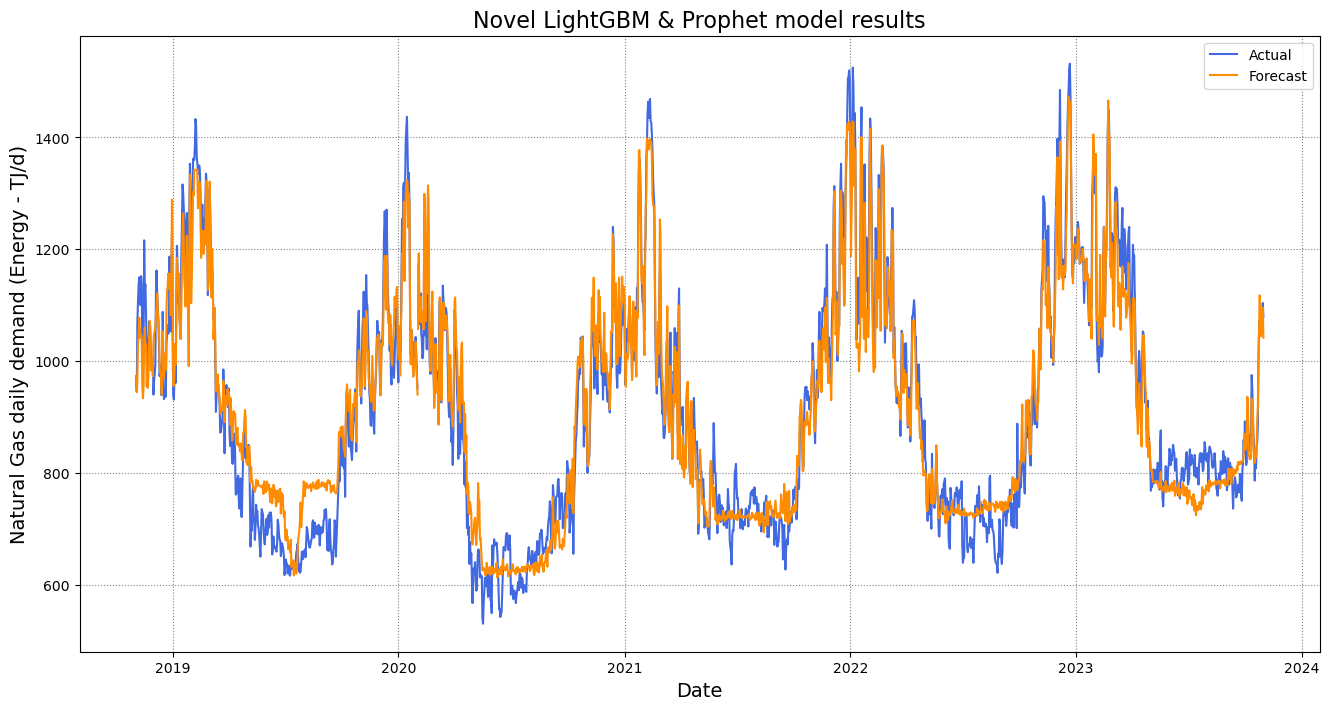

Average Mean Absolute Error: 41.703
Average Mean Squared Error: 2684.934
Average Root Mean Squared Error: 51.522
Average R-squared: 0.940
Average Mean Absolute Percentage Error: 4.868%
Average Median Absolute Percentage Error: 4.061%


{'avg_mae_nlph': 41.70260002598835,
 'avg_mse_nlph': 2684.9337845170694,
 'avg_rmse_nlph': 51.52220099053882,
 'avg_r2_nlph': 0.9401760250901559,
 'avg_mape_nlph': 4.8681368089578205,
 'avg_mdape_nlph': 4.060844105055407}

In [12]:
# Importing the necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

def train_time_series_with_folds_autoreg_prophet_features(df, initials=1825, period=456, horizon=456, lags=[1, 2, 3, 4, 5]): 
    # Create a dataframe containing all the new features created with Prophet
    new_prophet_features = prophet_features(df, horizon=horizon) 

    # Check if 'level_0' already exists before resetting the index
    if 'level_0' not in df.columns:
        df.reset_index(inplace=True)

    # Convert 'DATE' column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])
    
    # Merge the Prophet features dataframe with our initial dataframe
    df = pd.merge(df, new_prophet_features, left_on=['DATE'], right_on=['ds'], how='inner') 
    df.drop(['ds'], axis=1, inplace=True)  # Drop unnecessary columns
    df.set_index('DATE', inplace=True)

    # Use Prophet predictions to create some lag variables (yhat column)
    for lag in lags: 
        df[f'yhat_lag_{lag}'] = df['yhat'].shift(lag) 
    df.dropna(axis=0, how='any', inplace=True)  # Drop rows with NaN values

    # Defining the LightGBM model
    model = LGBMRegressor(random_state=42)

    # Setting up time series cross-validation with specified 4 folds
    tscv = TimeSeriesSplit(n_splits=4, max_train_size=initials, test_size=horizon, gap=0)

    # Lists to store evaluation metrics for each fold
    mae_scores, mse_scores, rmse_scores, r2_scores, mape_scores, mdape_scores = [], [], [], [], [], []

    plt.figure(figsize=(16, 8))
    plt.title('Novel LightGBM & Prophet model results', fontsize=16)

    for i, (train_index, test_index) in enumerate(tscv.split(df)):
        X_train, X_test = df.iloc[train_index].drop('NG_DEMAND', axis=1), df.iloc[test_index].drop('NG_DEMAND', axis=1)
        y_train, y_test = df.iloc[train_index]['NG_DEMAND'], df.iloc[test_index]['NG_DEMAND']

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        predictions = model.predict(X_test)

        # Evaluate performance metrics
        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, predictions)
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
        mdape = np.median(np.abs((y_test - predictions) / y_test)) * 100

        # Plot the real vs prediction for each fold
        plt.plot(df.index[test_index], y_test.values, color='royalblue', label='Actual')
        plt.plot(df.index[test_index], predictions, color='darkorange', label='Forecast')

        # Store metrics for later
        mae_scores.append(mae)
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        mape_scores.append(mape)
        mdape_scores.append(mdape)

    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Natural Gas daily demand (Energy - TJ/d)', fontsize=14)
   
    # Only add the legend once
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.grid(linestyle=":", color='grey')
    plt.show()

    # Calculate average performance metrics
    avg_mae_nlph = np.mean(mae_scores)
    avg_mse_nlph = np.mean(mse_scores)
    avg_rmse_nlph = np.mean(rmse_scores)
    avg_r2_nlph = np.mean(r2_scores)
    avg_mape_nlph = np.mean(mape_scores)
    avg_mdape_nlph = np.mean(mdape_scores)

    print(f'Average Mean Absolute Error: {avg_mae_nlph:.3f}')
    print(f'Average Mean Squared Error: {avg_mse_nlph:.3f}')
    print(f'Average Root Mean Squared Error: {avg_rmse_nlph:.3f}')
    print(f'Average R-squared: {avg_r2_nlph:.3f}')
    print(f'Average Mean Absolute Percentage Error: {avg_mape_nlph:.3f}%')
    print(f'Average Median Absolute Percentage Error: {avg_mdape_nlph:.3f}%')

    # Return the average performance metrics
    return {
        'avg_mae_nlph': avg_mae_nlph,
        'avg_mse_nlph': avg_mse_nlph,
        'avg_rmse_nlph': avg_rmse_nlph,
        'avg_r2_nlph': avg_r2_nlph,
        'avg_mape_nlph': avg_mape_nlph,
        'avg_mdape_nlph': avg_mdape_nlph
    }

# Calling function to model the provided dataset
train_time_series_with_folds_autoreg_prophet_features(selected_features_df)

02:21:22 - cmdstanpy - INFO - Chain [1] start processing
02:21:23 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Total Bins 4784
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 19
[LightGBM] [Info] Start training from score 787.220822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

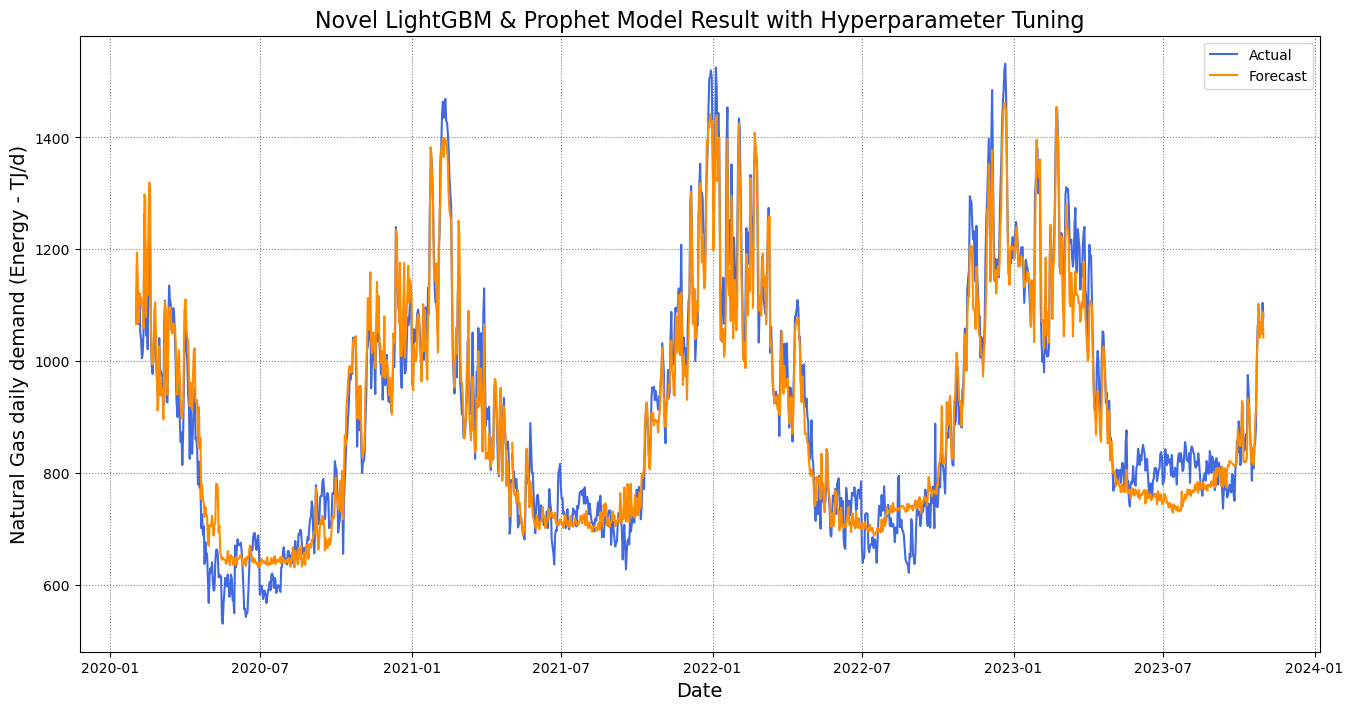

Average Mean Absolute Error: 39.041
Average Mean Squared Error: 2359.873
Average Root Mean Squared Error: 48.455
Average R-squared: 0.946
Average Mean Absolute Percentage Error: 4.511%
Average Median Absolute Percentage Error: 3.777%


{'avg_mae_hyp': 39.04126047014726,
 'avg_mse_hyp': 2359.872776674356,
 'avg_rmse_hyp': 48.45497104178168,
 'avg_r2_hyp': 0.946346430042456,
 'avg_mape_hyp': 4.511376362926209,
 'avg_mdape_hyp': 3.777460500555666}

In [13]:
# Importing the necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def train_time_series_with_folds_autoreg_prophet_features(df, initials=1825, period=456, horizon=456, lags=[1, 2, 3, 4, 5]):
    # Creating a dataframe containing all the new features created with Prophet
    new_prophet_features = prophet_features(df, horizon=horizon)

    # Checking if 'level_0' already exists before resetting the index
    if 'level_0' not in df.columns:
        df.reset_index(inplace=True)

    # Converting 'DATE' column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Merging the Prophet features dataframe with our initial dataframe
    df = pd.merge(df, new_prophet_features, left_on='DATE', right_on='ds', how='inner')
    df.drop(['ds'], axis=1, inplace=True)  # Drop unnecessary columns
    df.set_index('DATE', inplace=True)

    # Using Prophet predictions to create some lag variables (yhat column)
    for lag in lags:
        df[f'yhat_lag_{lag}'] = df['yhat'].shift(lag)
    df.dropna(axis=0, how='any', inplace=True)  # Drop rows with NaN values

    # Adding additional regressors
    additional_regressors = ['LOWEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
                            'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE']
    df[additional_regressors] = df[additional_regressors]

    # Defining the parameter grid for hyperparameter tuning
    param_grid = {
        'lgbm__n_estimators': [50, 100, 200],
        'lgbm__learning_rate': [0.01, 0.1, 0.2],
        'lgbm__max_depth': [5, 10, 15],
        'lgbm__lambda_l1': [0, 0.1, 0.5, 1],
        'lgbm__lambda_l2': [0, 0.1, 0.5, 1],
        'lgbm__min_gain_to_split': [0, 0.1, 0.5, 1],
        'lgbm__num_leaves': [31, 50, 100, 200]
    }

    # Defining the LightGBM model
    model = Pipeline([
        ('scaler', StandardScaler()),  # Standardize features
        ('lgbm', LGBMRegressor(force_col_wise=True,random_state=42))  # LGBM model
    ])

    # Setting up time series cross-validation with specified 3 folds
    tscv = TimeSeriesSplit(n_splits=3, max_train_size=initials, test_size=horizon, gap=0)
    
    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

    # Lists to store evaluation metrics for each fold
    mae_scores, mse_scores, rmse_scores, r2_scores, mape_scores, mdape_scores = [], [], [], [], [], []

    plt.figure(figsize=(16, 8))
    plt.title('Novel LightGBM & Prophet Model Result with Hyperparameter Tuning', fontsize=16)

    for i, (train_index, test_index) in enumerate(tscv.split(df)):
        X_train, X_test = df.iloc[train_index].drop('NG_DEMAND', axis=1), df.iloc[test_index].drop('NG_DEMAND', axis=1)
        y_train, y_test = df.iloc[train_index]['NG_DEMAND'], df.iloc[test_index]['NG_DEMAND']

        # Train the model using GridSearchCV
        random_search.fit(X_train, y_train)

        # Get the best parameters
        best_params = random_search.best_params_

        # Make predictions using the model with the best parameters
        predictions = random_search.predict(X_test)

        # Evaluate performance metrics
        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        r2 = 1 - (mse / np.var(y_test))
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
        mdape = np.median(np.abs((y_test - predictions) / y_test)) * 100

        # Plot the real vs prediction for each fold
        plt.plot(df.index[test_index], y_test.values, color='royalblue', label='Actual')
        plt.plot(df.index[test_index], predictions, color='darkorange', label='Forecast')

        # Store metrics for later
        mae_scores.append(mae)
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        mape_scores.append(mape)
        mdape_scores.append(mdape)

    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Natural Gas daily demand (Energy - TJ/d)', fontsize=14)
    
    # Only add the legend once
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.grid(linestyle=":", color='grey')
    plt.show()

    # Calculate average performance metrics from all the folds
    avg_mae_hyp = np.mean(mae_scores)
    avg_mse_hyp = np.mean(mse_scores)
    avg_rmse_hyp = np.mean(rmse_scores)
    avg_r2_hyp = np.mean(r2_scores)
    avg_mape_hyp = np.mean(mape_scores)
    avg_mdape_hyp = np.mean(mdape_scores)

    # Print the model performance metrics
    print(f'Average Mean Absolute Error: {avg_mae_hyp:.3f}')
    print(f'Average Mean Squared Error: {avg_mse_hyp:.3f}')
    print(f'Average Root Mean Squared Error: {avg_rmse_hyp:.3f}')
    print(f'Average R-squared: {avg_r2_hyp:.3f}')
    print(f'Average Mean Absolute Percentage Error: {avg_mape_hyp:.3f}%')
    print(f'Average Median Absolute Percentage Error: {avg_mdape_hyp:.3f}%')
        
    # Return the average performance metrics
    return {
        'avg_mae_hyp': avg_mae_hyp,
        'avg_mse_hyp': avg_mse_hyp,
        'avg_rmse_hyp': avg_rmse_hyp,
        'avg_r2_hyp': avg_r2_hyp,
        'avg_mape_hyp': avg_mape_hyp,
        'avg_mdape_hyp': avg_mdape_hyp
    }

# Calling function to model the dataset
train_time_series_with_folds_autoreg_prophet_features(selected_features_df)

C:\Users\davin\anaconda3\envs\projenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\davin\anaconda3\envs\projenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\davin\anaconda3\envs\projenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\davin\anaconda3\envs\projenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\davin\anaconda3\envs\projenv\lib\site-p

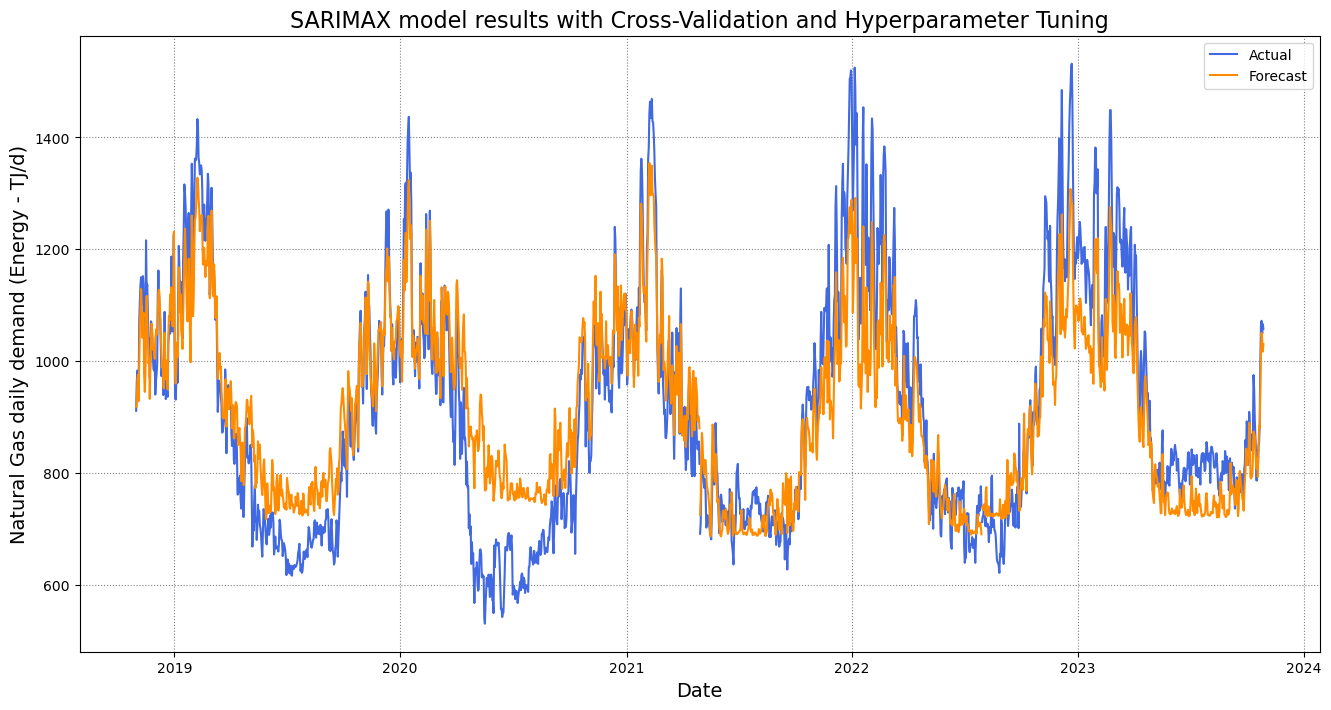

Average MSE: 8375.278
Average RMSE: 90.474
Average MAPE: 8.428
Average MAE: 72.622
Average MDAPE: 6.896
Average R^2: 0.811


In [16]:
import warnings
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'DATE' is in string format, convert it to datetime
selected_features_df['DATE'] = pd.to_datetime(selected_features_df['DATE'])

class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order, seasonal_order):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = None

    def fit(self, X, y):
        self.model = SARIMAX(y, exog=X, order=self.order, seasonal_order=self.seasonal_order)
        self.results = self.model.fit(disp=True, maxiter=10)
        return self

    def predict(self, X):
        forecast_steps = X.shape[0]
        return self.results.get_forecast(steps=forecast_steps, exog=X).predicted_mean

# Choose the target variable (NG_DEMAND in this case) and independent variables
y = selected_features_df['NG_DEMAND']
X = selected_features_df[['DATE', 'LOWEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'LOWEST_TEMPERATURE',
               'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE']]
#(3, 0, 0)x(2, 1, 0, 12)
# Define the SARIMA model order
order = (1, 1, 1)  # (p, d, q) non-seasonal part
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, S) seasonal part

# Convert 'DATE' to datetime
X['DATE'] = pd.to_datetime(X['DATE'])

# Define training and test set sizes
initials = 1825
horizon = 456

# Initialize the total performance metrics
total_mse, total_rmse, total_mape, total_mae, total_mdape, total_r2 = 0, 0, 0, 0, 0, 0

# Create a figure before the loop
plt.figure(figsize=(16, 8))

# Define the pipeline
pipeline = Pipeline([
    ('sarimax', SARIMAXWrapper(order=order, seasonal_order=seasonal_order))
])

# Define hyperparameter grid
param_grid = {
    'sarimax__order': [(1, 1, 1), (1, 0, 1)],
    'sarimax__seasonal_order': [(1, 1, 1, 12), (1, 0, 1, 12)]
}

# Perform time series cross-validation with rolling basis and hyperparameter tuning
tscv = TimeSeriesSplit(n_splits=4)
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X.drop(columns=['DATE']), y)

# Get the best model
best_model = grid_search.best_estimator_

# Perform time series cross-validation with rolling basis using the best model
for i in range(4):
    # Split the data into training and test sets
    train_end = initials + i * horizon
    test_start = train_end
    test_end = test_start + horizon

    X_train, X_test = X.iloc[:train_end], X.iloc[test_start:test_end]
    y_train, y_test = y.iloc[:train_end], y.iloc[test_start:test_end]

    # Fit SARIMA model with exogenous variables using the best model
    best_model.fit(X_train.drop(columns=['DATE']), y_train)

    # Forecast future values
    y_pred = best_model.predict(X_test.drop(columns=['DATE']))

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mae = mean_absolute_error(y_test, y_pred)
    mdape = np.median(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    # Add the performance metrics to the total
    total_mse += mse
    total_rmse += rmse
    total_mape += mape
    total_mae += mae
    total_mdape += mdape
    total_r2 += r2

    # Plot the forecast and actuals
    plt.plot(X_test['DATE'], y_test, color='royalblue', label='Actual')
    plt.plot(X_test['DATE'], y_pred, color='darkorange', label='Forecast')

# Add title, labels, and legend after the loop
plt.title('SARIMAX model results with Cross-Validation and Hyperparameter Tuning', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Natural Gas daily demand (Energy - TJ/d)', fontsize=14)

# Only add the legend once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid(linestyle=":", color='grey')
plt.show()

# Calculate the average performance metrics
mse_sarimax = total_mse / 4
rmse_sarimax = total_rmse / 4
mape_sarimax = total_mape / 4
mae_sarimax = total_mae / 4
mdape_sarimax = total_mdape / 4
r2_sarimax = total_r2 / 4

# Print the results
print(f'Average MSE: {mse_sarimax:.3f}')
print(f'Average RMSE: {rmse_sarimax:.3f}')
print(f'Average MAPE: {mape_sarimax:.3f}')
print(f'Average MAE: {mae_sarimax:.3f}')
print(f'Average MDAPE: {mdape_sarimax:.3f}')
print(f'Average R^2: {r2_sarimax:.3f}')
